In [2]:
import os,sys,inspect
import os
import joblib
import tensorflow.compat.v1 as tf
import numpy as np
import h5py
import scipy.sparse.linalg as la
import scipy.sparse as sp
import scipy
import time

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
%matplotlib inline

In [3]:
path_dataset = '/Users/liujiaoyang/tensorflow/HGCRNN_01867787/Data/Movielens/MovieLens.mat' #with only social network
path_implicit = '/Users/liujiaoyang/tensorflow/HGCRNN_01867787/Data/Movielens/S_implicit.mat'

In [4]:
# auxiliary functions:

# import matlab files in python
def load_matlab_file(path_file, name_field):
    """
    load '.mat' files
    inputs:
        path_file, string containing the file path
        name_field, string containig the field name (default='shape')
    warning:
        '.mat' files should be saved in the '-v7.3' format
    """
    db = h5py.File(path_file, 'r')
    ds = db[name_field]
    try:
        if 'ir' in ds.keys():
            data = np.asarray(ds['data'])
            ir   = np.asarray(ds['ir'])
            jc   = np.asarray(ds['jc'])
            out  = sp.csc_matrix((data, ir, jc)).astype(np.float32)
    except AttributeError:
        # Transpose in case is a dense matrix because of the row- vs column- major ordering between python and matlab
        out = np.asarray(ds).astype(np.float32).T

    db.close()

    return out

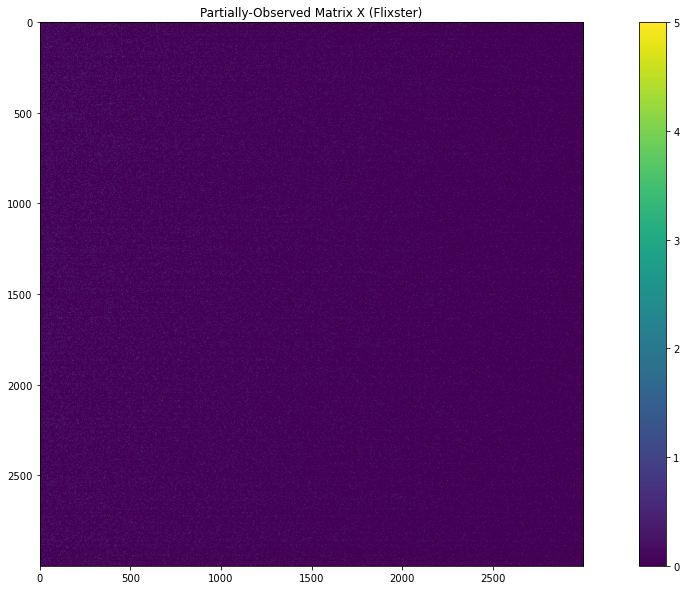

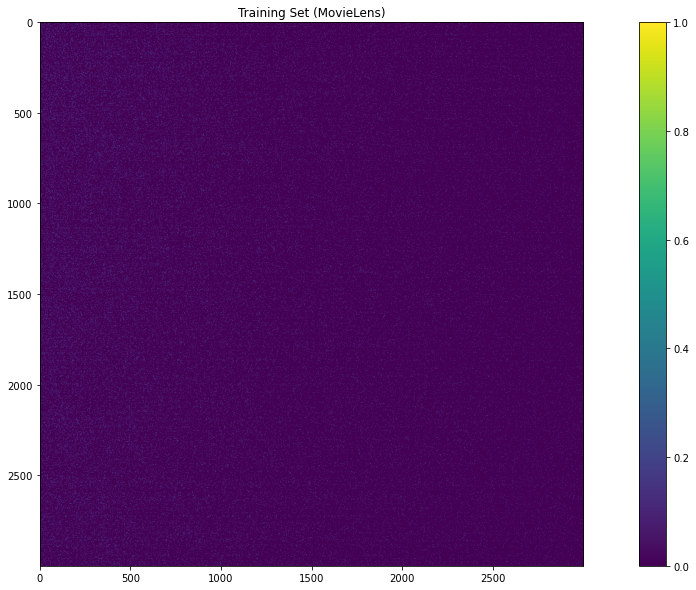

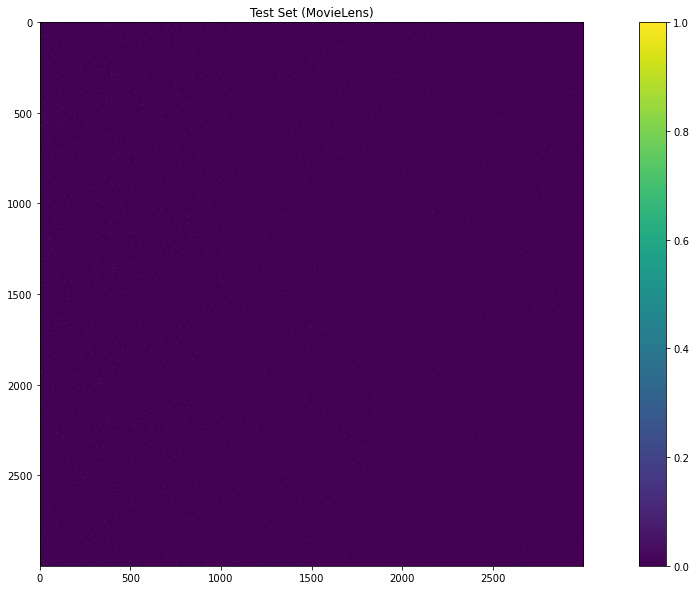

In [5]:
#loading of the required matrices
M = load_matlab_file(path_dataset, 'M')
Otraining = load_matlab_file(path_dataset, 'Otraining')
Otest = load_matlab_file(path_dataset, 'Otest')
Wcol = load_matlab_file(path_dataset, 'W_movies') #sparse
Sb_imp = load_matlab_file(path_implicit, 'Sb_imp')

plt.figure(figsize=(20,10))
plt.imshow(M)
plt.title('Partially-Observed Matrix X (MovieLens)')
plt.colorbar()

plt.figure(figsize=(20,10))
plt.imshow(Otraining)
plt.title('Training Set (MovieLens)')
plt.colorbar()

plt.figure(figsize=(20,10))
plt.imshow(Otest)
plt.title('Test Set (MovieLens)')
plt.colorbar()

In [ ]:
# extract implicit features
item_impGraph = kneighbors_graph(Sb_imp, 10)

# save sparse matrix
sp.save_npz('item_impGraph.npz', item_impGraph, False)

# print
print(item_impGraph.shape)
print(Wcol.shape)

In [ ]:
# combine explicit and implicit graphs
Wcol = 0.8 * Wcol + 0.2 * item_impGraph

In [6]:
np.random.seed(0) #Initialize the random number generator.
pos_tr_samples = np.where(Otraining) #返回Otraining中不为零的值的坐标

num_tr_samples = len(pos_tr_samples[0]) #不为零的个数
list_idx = list(range(num_tr_samples))
np.random.shuffle(list_idx)
idx_data = list_idx[:num_tr_samples//2]
idx_train = list_idx[num_tr_samples//2:]

pos_data_samples = (pos_tr_samples[0][idx_data], pos_tr_samples[1][idx_data])
pos_tr_samples = (pos_tr_samples[0][idx_train], pos_tr_samples[1][idx_train])

Odata = np.zeros(M.shape)
Otraining = np.zeros(M.shape)

for k in range(len(pos_data_samples[0])):
    Odata[pos_data_samples[0][k], pos_data_samples[1][k]] = 1
    
for k in range(len(pos_tr_samples[0])):
    Otraining[pos_tr_samples[0][k], pos_tr_samples[1][k]] = 1
    
print ('Num data samples: %d' % (np.sum(Odata),))
print ('Num train samples: %d' % (np.sum(Otraining),))
print ('Num train+data samples: %d' % (np.sum(Odata+Otraining),))

Num data samples: 61601
Num train samples: 61601
Num train+data samples: 123202


In [7]:
#computation of the normalized laplacians
Lcol = sp.csgraph.laplacian(Wcol, normed=True)

In [8]:
#apply SVD initially for detecting the main components of our initialization
U, s, V = np.linalg.svd(Odata*M, full_matrices=0)

print (U.shape)
print (s.shape)
print (V.shape)

(3000, 3000)
(3000,)
(3000, 3000)


(3000, 10)
(3000, 10)


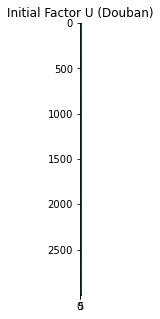

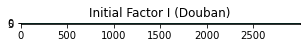

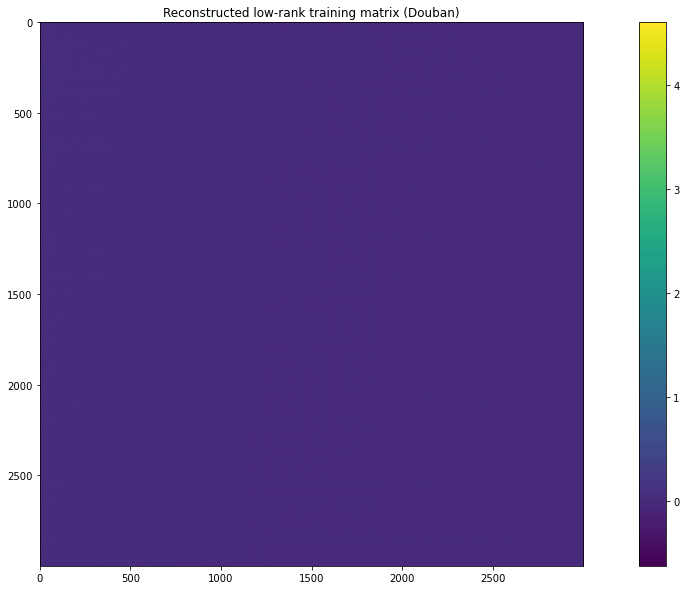

In [10]:
rank_W_H = 10
partial_s = s[:rank_W_H]
partial_S_sqrt = np.diag(np.sqrt(partial_s))
initial_W = np.dot(U[:, :rank_W_H], partial_S_sqrt)
initial_H = np.dot(partial_S_sqrt, V[:rank_W_H, :]).T

print (initial_W.shape)
print (initial_H.shape)

plt.figure(figsize=(20,5))
plt.imshow(initial_W)
plt.title('Initial Factor U (MovieLens)')


plt.figure(figsize=(5,20))
plt.imshow(initial_H.T)
plt.title('Initial Factor I (MovieLens)')


plt.figure(figsize=(20,10))
plt.imshow(np.dot(initial_W, initial_H.T))
plt.title('Reconstructed low-rank training matrix (MovieLens)')
plt.colorbar()

Original training matrix
Reconstructed training matrix


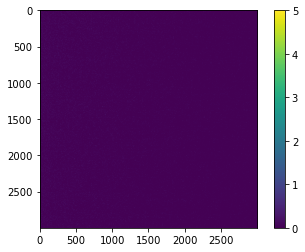

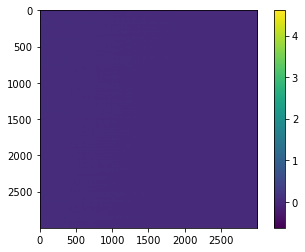

In [9]:
plt.figure()
plt.imshow(Odata*M)
plt.title('Original training matrix')
plt.colorbar()

plt.figure()
plt.imshow(np.dot(initial_W, initial_H.T))
plt.title('Reconstructed training matrix')
plt.colorbar()

In [10]:
class Train_test_matrix_completion:
    
    """
    The neural network model.
    """
    
    def frobenius_norm(self, tensor):
        square_tensor = tf.square(tensor)
        tensor_sum = tf.reduce_sum(square_tensor)
        frobenius_norm = tf.sqrt(tensor_sum)
        return frobenius_norm
    
    def mono_conv(self, list_lap, ord_conv, A, W, b):
        
        feat = []
        #collect features
        for k in range(ord_conv):
            c_lap = list_lap[k] 
                                                     
            #dense implementation
            c_feat = tf.matmul(c_lap, A, a_is_sparse=False)
            feat.append(c_feat)
            
        all_feat = tf.concat(feat,1)
        conv_feat = tf.matmul(all_feat, W) + b
        conv_feat = tf.nn.relu(conv_feat)
        
        return conv_feat
                
    def compute_cheb_polynomials(self, L, ord_cheb, list_cheb):
        for k in range(ord_cheb):
            if (k==0):
                list_cheb.append(tf.cast(tf.diag(tf.ones([tf.shape(L)[0],])), 'float32'))
            elif (k==1):
                list_cheb.append(tf.cast(L, 'float32'))
            else:
                list_cheb.append(2*tf.matmul(L, list_cheb[k-1])  - list_cheb[k-2])
                 
    def __init__(self, M, Lr, Odata, Otraining, Otest, initial_W, initial_H,
                 order_chebyshev_row = 5,
                 num_iterations = 10, gamma=1.0, gamma_H=1.0, gamma_W=1.0, learning_rate=1e-4, idx_gpu = '/gpu:1'):
        
        #order of the spectral filters
        self.ord_row = order_chebyshev_row
        self.num_iterations = num_iterations
        self.n_conv_feat = 32
        
        with tf.Graph().as_default() as g:
                tf.logging.set_verbosity(tf.logging.ERROR)
                self.graph = g
                tf.set_random_seed(0)
                with tf.device(idx_gpu):
                    
                        #loading of the laplacians
                        self.Lr = tf.cast(Lr, 'float32')
                        
                        self.norm_Lr = self.Lr - tf.diag(tf.ones([Lr.shape[0], ]))
                        
                        #compute all chebyshev polynomials a priori
                        self.list_row_cheb_pol = list()
                        self.compute_cheb_polynomials(self.norm_Lr, self.ord_row, self.list_row_cheb_pol)
                        
                        #definition of constant matrices
                        self.M = tf.constant(M, dtype=tf.float32)
                        self.Odata = tf.constant(Odata, dtype=tf.float32)
                        self.Otraining = tf.constant(Otraining, dtype=tf.float32) #training mask
                        self.Otest = tf.constant(Otest, dtype=tf.float32) #test mask
                         
                        ##################################definition of the NN variables#####################################
                        
                        #definition of the weights for extracting the global features
                        self.W_conv_W = tf.get_variable("W_conv_W", shape=[self.ord_row*initial_W.shape[1], self.n_conv_feat], initializer=tf.glorot_uniform_initializer())
                        self.b_conv_W = tf.Variable(tf.zeros([self.n_conv_feat,]))
                        
                        #recurrent N parameters
                        self.W_f_u = tf.get_variable("W_f_u", shape=[self.n_conv_feat, self.n_conv_feat], initializer=tf.glorot_uniform_initializer())
                        self.W_i_u = tf.get_variable("W_i_u", shape=[self.n_conv_feat, self.n_conv_feat], initializer=tf.glorot_uniform_initializer())
                        self.W_o_u = tf.get_variable("W_o_u", shape=[self.n_conv_feat, self.n_conv_feat], initializer=tf.glorot_uniform_initializer())
                        self.W_c_u = tf.get_variable("W_c_u", shape=[self.n_conv_feat, self.n_conv_feat], initializer=tf.glorot_uniform_initializer())
                        self.U_f_u = tf.get_variable("U_f_u", shape=[self.n_conv_feat, self.n_conv_feat], initializer=tf.glorot_uniform_initializer())
                        self.U_i_u = tf.get_variable("U_i_u", shape=[self.n_conv_feat, self.n_conv_feat], initializer=tf.glorot_uniform_initializer())
                        self.U_o_u = tf.get_variable("U_o_u", shape=[self.n_conv_feat, self.n_conv_feat], initializer=tf.glorot_uniform_initializer())
                        self.U_c_u = tf.get_variable("U_c_u", shape=[self.n_conv_feat, self.n_conv_feat], initializer=tf.glorot_uniform_initializer())
                        self.b_f_u = tf.Variable(tf.zeros([self.n_conv_feat,]))
                        self.b_i_u = tf.Variable(tf.zeros([self.n_conv_feat,]))
                        self.b_o_u = tf.Variable(tf.zeros([self.n_conv_feat,]))
                        self.b_c_u = tf.Variable(tf.zeros([self.n_conv_feat,]))
                        
                        #output parameters
                        self.W_out_W = tf.get_variable("W_out_W", shape=[self.n_conv_feat, initial_W.shape[1]], initializer=tf.glorot_uniform_initializer()) 
                        self.b_out_W = tf.Variable(tf.zeros([initial_W.shape[1],]))
                        
                        #########definition of the NN
                        #definition of W and H
                        self.W = tf.constant(initial_W.astype('float32'))
                        self.H = tf.Variable(initial_H.astype('float32'))
                        
                        self.X = tf.matmul(self.W, self.H, transpose_b=True) #we may initialize it at random here
                        self.list_X = list()
                        self.list_X.append(tf.identity(self.X))
                        
                        #RNN
                        self.h_u = tf.zeros([M.shape[0], self.n_conv_feat])
                        self.c_u = tf.zeros([M.shape[0], self.n_conv_feat])
                        
                        
                        for k in range(self.num_iterations):
                            #extraction of global features vectors
                            self.final_feat_users = self.mono_conv(self.list_row_cheb_pol, self.ord_row, self.W, self.W_conv_W, self.b_conv_W)
                            
                            #here we have to split the features between users and movies LSTMs
                            
                            #users RNN
                            self.f_u = tf.sigmoid(tf.matmul(self.final_feat_users, self.W_f_u) + tf.matmul(self.h_u, self.U_f_u) + self.b_f_u)
                            self.i_u = tf.sigmoid(tf.matmul(self.final_feat_users, self.W_i_u) + tf.matmul(self.h_u, self.U_i_u) + self.b_i_u)
                            self.o_u = tf.sigmoid(tf.matmul(self.final_feat_users, self.W_o_u) + tf.matmul(self.h_u, self.U_o_u) + self.b_o_u)
                            
                            self.update_c_u = tf.sigmoid(tf.matmul(self.final_feat_users, self.W_c_u) + tf.matmul(self.h_u, self.U_c_u) + self.b_c_u)
                            self.c_u = tf.multiply(self.f_u, self.c_u) + tf.multiply(self.i_u, self.update_c_u)
                            self.h_u = tf.multiply(self.o_u, tf.sigmoid(self.c_u))
                            
                            #compute update of matrix X
                            self.delta_W = tf.tanh(tf.matmul(self.c_u, self.W_out_W) + self.b_out_W) #N x rank_W_H
                            
                            self.W += self.delta_W
                        
                            self.X = tf.matmul(self.W, self.H, transpose_b=True)
                            self.list_X.append(tf.identity(tf.reshape(self.X, [tf.shape(self.M)[0], tf.shape(self.M)[1]])))
                        self.X = tf.matmul(self.W, self.H, transpose_b=True)
                        #########loss definition
                        
                        #computation of the accuracy term
                        self.norm_X = 1+4*(self.X-tf.reduce_min(self.X))/(tf.reduce_max(self.X-tf.reduce_min(self.X)))
                        frob_tensor = tf.multiply(self.Otraining + self.Odata, self.norm_X - M)
                        self.loss_frob = tf.square(self.frobenius_norm(frob_tensor))/np.sum(Otraining+Odata)
                        
                        #computation of the regularization terms
                        trace_row_tensor = tf.matmul(tf.matmul(self.X, self.Lr, transpose_a=True), self.X)
                        self.loss_trace_row = tf.trace(trace_row_tensor)/tf.cast(tf.shape(self.X)[0]*tf.shape(self.X)[1],'float32')
                        
                        self.frob_norm_H = tf.square(self.frobenius_norm(self.H))/tf.cast(tf.shape(self.H)[0]*tf.shape(self.H)[1], 'float32')
                        self.frob_norm_W = tf.square(self.frobenius_norm(self.W))/tf.cast(tf.shape(self.W)[0]*tf.shape(self.W)[1], 'float32')
                        
                        
                        #training loss definition
                        self.loss = self.loss_frob + (gamma/2)*self.loss_trace_row + (gamma_H/2)*self.frob_norm_H + (gamma_W/2)*self.frob_norm_W
                        
                        #test loss definition
                        self.predictions = tf.multiply(self.Otest, self.norm_X - self.M)
                        self.predictions_error = self.frobenius_norm(self.predictions)

                        #definition of the solver
                        self.optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(self.loss)
                        
                        self.var_grad = tf.gradients(self.loss, tf.trainable_variables())
                        self.norm_grad = self.frobenius_norm(tf.concat([tf.reshape(g, [-1]) for g in self.var_grad],0))

                        # Create a session for running Ops on the Graph.
                        config = tf.ConfigProto(allow_soft_placement = True)
                        config.gpu_options.allow_growth = True
                        self.session = tf.Session(config=config)

                        # Run the Op to initialize the variables.
                        init = tf.initialize_all_variables()
                        self.session.run(init)

In [11]:
ord_col = 5
ord_row = 5

        
learning_obj = Train_test_matrix_completion(M, Lcol, Odata, Otraining, Otest, 
                                                    initial_W, initial_H,
                                                    order_chebyshev_row = ord_row, 
                                                    gamma=1e2, gamma_H=1e2, gamma_W=1e0,
                                                    learning_rate=1e-3)

num_iter_test = 10
num_total_iter_training = 5000

num_iter = 0

list_training_loss = list()
list_training_norm_grad = list()
list_test_pred_error = list()
list_predictions = list()
list_X = list()

list_training_times = list()
list_test_times = list()
list_grad_X = list()

list_X_evolutions = list()

In [13]:
num_iter = 0
for k in range(num_iter, num_total_iter_training):

    tic = time.time()
    _, current_training_loss, norm_grad, X_grad = learning_obj.session.run([learning_obj.optimizer, learning_obj.loss, 
                                                                                        learning_obj.norm_grad, learning_obj.var_grad]) 
    training_time = time.time() - tic

    list_training_loss.append(current_training_loss)
    list_training_norm_grad.append(norm_grad)
    list_training_times.append(training_time)

    if (np.mod(num_iter, num_iter_test)==0):
        msg = "[TRN] iter = %03i, cost = %3.2e, |grad| = %.2e (%3.2es)" \
                                    % (num_iter, list_training_loss[-1], list_training_norm_grad[-1], training_time)
        print (msg)

        #Test Code
        tic = time.time()
        pred_error, preds, X = learning_obj.session.run([learning_obj.predictions_error, learning_obj.predictions,
                                                                             learning_obj.norm_X]) 
        test_time = time.time() - tic

        list_test_pred_error.append(pred_error)
        list_test_times.append(test_time)
            
        RMSE = np.sqrt(np.square(pred_error)/np.sum(Otest))
        msg =  "[TST] iter = %03i, cost = %3.2e, RMSE = %3.2e (%3.2es)" % (num_iter, list_test_pred_error[-1], RMSE, test_time)
        print (msg)
            
    num_iter += 1

[TRN] iter = 000, cost = 3.31e+01, |grad| = 8.59e+01 (1.14e+01s)
[TST] iter = 000, cost = 1.26e+02, RMSE = 1.07e+00 (5.54e+00s)
[TRN] iter = 010, cost = 1.15e+01, |grad| = 3.41e+01 (1.93e+00s)
[TST] iter = 010, cost = 1.21e+02, RMSE = 1.03e+00 (4.92e-01s)
[TRN] iter = 020, cost = 4.85e+00, |grad| = 1.63e+01 (1.77e+00s)
[TST] iter = 020, cost = 1.14e+02, RMSE = 9.71e-01 (4.90e-01s)
[TRN] iter = 030, cost = 2.84e+00, |grad| = 9.30e+00 (1.77e+00s)
[TST] iter = 030, cost = 1.10e+02, RMSE = 9.39e-01 (4.87e-01s)
[TRN] iter = 040, cost = 2.24e+00, |grad| = 4.38e+00 (1.81e+00s)
[TST] iter = 040, cost = 1.09e+02, RMSE = 9.31e-01 (4.94e-01s)
[TRN] iter = 050, cost = 2.02e+00, |grad| = 2.70e+00 (1.82e+00s)
[TST] iter = 050, cost = 1.07e+02, RMSE = 9.18e-01 (5.01e-01s)
[TRN] iter = 060, cost = 1.92e+00, |grad| = 1.97e+00 (1.83e+00s)
[TST] iter = 060, cost = 1.07e+02, RMSE = 9.16e-01 (5.01e-01s)
[TRN] iter = 070, cost = 1.85e+00, |grad| = 1.73e+00 (1.81e+00s)
[TST] iter = 070, cost = 1.07e+02, RMSE

[TST] iter = 640, cost = 1.04e+02, RMSE = 8.90e-01 (4.74e-01s)
[TRN] iter = 650, cost = 1.08e+00, |grad| = 2.58e+00 (1.75e+00s)
[TST] iter = 650, cost = 1.01e+02, RMSE = 8.64e-01 (4.67e-01s)
[TRN] iter = 660, cost = 1.05e+00, |grad| = 1.58e+00 (1.72e+00s)
[TST] iter = 660, cost = 9.95e+01, RMSE = 8.50e-01 (4.76e-01s)
[TRN] iter = 670, cost = 1.03e+00, |grad| = 7.42e+00 (1.74e+00s)
[TST] iter = 670, cost = 9.88e+01, RMSE = 8.45e-01 (4.80e-01s)
[TRN] iter = 680, cost = 1.03e+00, |grad| = 2.88e+00 (1.72e+00s)
[TST] iter = 680, cost = 9.85e+01, RMSE = 8.42e-01 (4.75e-01s)
[TRN] iter = 690, cost = 1.02e+00, |grad| = 4.59e+00 (1.73e+00s)
[TST] iter = 690, cost = 9.87e+01, RMSE = 8.44e-01 (4.76e-01s)
[TRN] iter = 700, cost = 1.01e+00, |grad| = 9.69e+00 (1.74e+00s)
[TST] iter = 700, cost = 1.00e+02, RMSE = 8.54e-01 (4.77e-01s)
[TRN] iter = 710, cost = 9.97e-01, |grad| = 1.94e+00 (1.74e+00s)
[TST] iter = 710, cost = 9.75e+01, RMSE = 8.34e-01 (4.71e-01s)
[TRN] iter = 720, cost = 9.89e-01, |grad|

[TST] iter = 1280, cost = 9.33e+01, RMSE = 7.97e-01 (4.51e-01s)
[TRN] iter = 1290, cost = 7.81e-01, |grad| = 2.17e+00 (2.88e+02s)
[TST] iter = 1290, cost = 9.32e+01, RMSE = 7.97e-01 (4.80e-01s)
[TRN] iter = 1300, cost = 7.84e-01, |grad| = 3.72e+00 (5.03e+00s)
[TST] iter = 1300, cost = 9.32e+01, RMSE = 7.96e-01 (1.69e+00s)
[TRN] iter = 1310, cost = 7.87e-01, |grad| = 1.59e+00 (3.45e+00s)
[TST] iter = 1310, cost = 9.34e+01, RMSE = 7.98e-01 (1.62e+00s)
[TRN] iter = 1320, cost = 7.90e-01, |grad| = 1.51e+00 (1.68e+00s)
[TST] iter = 1320, cost = 9.35e+01, RMSE = 7.99e-01 (4.51e-01s)
[TRN] iter = 1330, cost = 7.84e-01, |grad| = 1.78e+00 (4.96e+00s)
[TST] iter = 1330, cost = 9.34e+01, RMSE = 7.98e-01 (1.66e+00s)
[TRN] iter = 1340, cost = 7.80e-01, |grad| = 3.40e+00 (5.11e+00s)
[TST] iter = 1340, cost = 9.33e+01, RMSE = 7.97e-01 (1.64e+00s)
[TRN] iter = 1350, cost = 7.76e-01, |grad| = 3.93e+00 (1.71e+00s)
[TST] iter = 1350, cost = 9.31e+01, RMSE = 7.95e-01 (9.42e-01s)
[TRN] iter = 1360, cost = 

[TRN] iter = 1920, cost = 7.01e-01, |grad| = 7.39e-01 (1.75e+00s)
[TST] iter = 1920, cost = 9.27e+01, RMSE = 7.92e-01 (4.71e-01s)
[TRN] iter = 1930, cost = 6.97e-01, |grad| = 8.61e-01 (1.73e+00s)
[TST] iter = 1930, cost = 9.27e+01, RMSE = 7.92e-01 (4.78e-01s)
[TRN] iter = 1940, cost = 6.94e-01, |grad| = 8.95e+00 (1.75e+00s)
[TST] iter = 1940, cost = 9.29e+01, RMSE = 7.94e-01 (4.72e-01s)
[TRN] iter = 1950, cost = 6.94e-01, |grad| = 4.03e+00 (1.73e+00s)
[TST] iter = 1950, cost = 9.28e+01, RMSE = 7.93e-01 (4.75e-01s)
[TRN] iter = 1960, cost = 7.11e-01, |grad| = 4.19e+00 (1.74e+00s)
[TST] iter = 1960, cost = 9.40e+01, RMSE = 8.04e-01 (4.76e-01s)
[TRN] iter = 1970, cost = 7.12e-01, |grad| = 1.80e+00 (1.74e+00s)
[TST] iter = 1970, cost = 9.34e+01, RMSE = 7.98e-01 (4.75e-01s)
[TRN] iter = 1980, cost = 6.93e-01, |grad| = 1.09e+01 (1.74e+00s)
[TST] iter = 1980, cost = 9.27e+01, RMSE = 7.92e-01 (4.80e-01s)
[TRN] iter = 1990, cost = 7.41e-01, |grad| = 2.76e+00 (1.74e+00s)
[TST] iter = 1990, cost 

[TST] iter = 2550, cost = 9.26e+01, RMSE = 7.91e-01 (4.91e-01s)
[TRN] iter = 2560, cost = 6.52e-01, |grad| = 6.69e-01 (1.83e+00s)
[TST] iter = 2560, cost = 9.25e+01, RMSE = 7.91e-01 (4.94e-01s)
[TRN] iter = 2570, cost = 6.52e-01, |grad| = 1.32e+00 (1.83e+00s)
[TST] iter = 2570, cost = 9.26e+01, RMSE = 7.92e-01 (4.87e-01s)
[TRN] iter = 2580, cost = 6.55e-01, |grad| = 2.86e+00 (1.84e+00s)
[TST] iter = 2580, cost = 9.27e+01, RMSE = 7.92e-01 (4.92e-01s)
[TRN] iter = 2590, cost = 6.49e-01, |grad| = 9.85e-01 (1.82e+00s)
[TST] iter = 2590, cost = 9.25e+01, RMSE = 7.91e-01 (4.87e-01s)
[TRN] iter = 2600, cost = 6.59e-01, |grad| = 1.97e+00 (1.85e+00s)
[TST] iter = 2600, cost = 9.26e+01, RMSE = 7.91e-01 (4.87e-01s)
[TRN] iter = 2610, cost = 6.48e-01, |grad| = 8.45e-01 (1.83e+00s)
[TST] iter = 2610, cost = 9.28e+01, RMSE = 7.93e-01 (4.86e-01s)
[TRN] iter = 2620, cost = 7.74e-01, |grad| = 2.10e+00 (1.83e+00s)
[TST] iter = 2620, cost = 9.37e+01, RMSE = 8.01e-01 (4.91e-01s)
[TRN] iter = 2630, cost = 

[TRN] iter = 3190, cost = 6.37e-01, |grad| = 3.19e+00 (1.74e+00s)
[TST] iter = 3190, cost = 9.27e+01, RMSE = 7.93e-01 (4.70e-01s)
[TRN] iter = 3200, cost = 6.39e-01, |grad| = 8.30e-01 (1.73e+00s)
[TST] iter = 3200, cost = 9.29e+01, RMSE = 7.94e-01 (4.71e-01s)
[TRN] iter = 3210, cost = 6.32e-01, |grad| = 5.54e-01 (1.73e+00s)
[TST] iter = 3210, cost = 9.27e+01, RMSE = 7.92e-01 (4.74e-01s)
[TRN] iter = 3220, cost = 6.31e-01, |grad| = 5.48e-01 (1.73e+00s)
[TST] iter = 3220, cost = 9.28e+01, RMSE = 7.94e-01 (4.70e-01s)
[TRN] iter = 3230, cost = 6.63e-01, |grad| = 1.17e+01 (1.73e+00s)
[TST] iter = 3230, cost = 9.38e+01, RMSE = 8.01e-01 (4.72e-01s)
[TRN] iter = 3240, cost = 6.46e-01, |grad| = 1.24e+00 (1.71e+00s)
[TST] iter = 3240, cost = 9.25e+01, RMSE = 7.91e-01 (4.72e-01s)
[TRN] iter = 3250, cost = 6.39e-01, |grad| = 2.49e+00 (1.76e+00s)
[TST] iter = 3250, cost = 9.26e+01, RMSE = 7.92e-01 (4.69e-01s)
[TRN] iter = 3260, cost = 6.31e-01, |grad| = 6.57e+00 (1.75e+00s)
[TST] iter = 3260, cost 

[TST] iter = 3820, cost = 9.27e+01, RMSE = 7.93e-01 (1.65e+00s)
[TRN] iter = 3830, cost = 6.18e-01, |grad| = 8.76e-01 (5.01e+00s)
[TST] iter = 3830, cost = 9.26e+01, RMSE = 7.92e-01 (1.63e+00s)
[TRN] iter = 3840, cost = 6.17e-01, |grad| = 6.60e+00 (1.72e+00s)
[TST] iter = 3840, cost = 9.28e+01, RMSE = 7.93e-01 (4.50e-01s)
[TRN] iter = 3850, cost = 6.18e-01, |grad| = 1.11e+00 (1.75e+00s)
[TST] iter = 3850, cost = 9.32e+01, RMSE = 7.97e-01 (4.60e-01s)
[TRN] iter = 3860, cost = 6.14e-01, |grad| = 9.87e-01 (5.02e+00s)
[TST] iter = 3860, cost = 9.32e+01, RMSE = 7.96e-01 (1.69e+00s)
[TRN] iter = 3870, cost = 6.20e-01, |grad| = 2.44e+00 (4.96e+00s)
[TST] iter = 3870, cost = 9.31e+01, RMSE = 7.96e-01 (1.64e+00s)
[TRN] iter = 3880, cost = 6.16e-01, |grad| = 2.04e+00 (1.70e+00s)
[TST] iter = 3880, cost = 9.29e+01, RMSE = 7.94e-01 (4.61e-01s)
[TRN] iter = 3890, cost = 6.11e-01, |grad| = 1.27e+00 (1.79e+00s)
[TST] iter = 3890, cost = 9.28e+01, RMSE = 7.93e-01 (4.60e-01s)
[TRN] iter = 3900, cost = 

[TRN] iter = 4460, cost = 6.08e-01, |grad| = 4.94e-01 (5.01e+00s)
[TST] iter = 4460, cost = 9.27e+01, RMSE = 7.92e-01 (1.63e+00s)
[TRN] iter = 4470, cost = 6.05e-01, |grad| = 7.36e-01 (1.72e+00s)
[TST] iter = 4470, cost = 9.29e+01, RMSE = 7.94e-01 (4.54e-01s)
[TRN] iter = 4480, cost = 6.05e-01, |grad| = 1.88e+00 (2.86e+02s)
[TST] iter = 4480, cost = 9.29e+01, RMSE = 7.94e-01 (4.80e-01s)
[TRN] iter = 4490, cost = 5.99e-01, |grad| = 2.83e+00 (4.97e+00s)
[TST] iter = 4490, cost = 9.30e+01, RMSE = 7.95e-01 (1.60e+00s)
[TRN] iter = 4500, cost = 6.01e-01, |grad| = 1.29e+00 (5.01e+00s)
[TST] iter = 4500, cost = 9.32e+01, RMSE = 7.96e-01 (1.64e+00s)
[TRN] iter = 4510, cost = 6.03e-01, |grad| = 1.69e+00 (1.70e+00s)
[TST] iter = 4510, cost = 9.30e+01, RMSE = 7.95e-01 (4.55e-01s)
[TRN] iter = 4520, cost = 6.44e-01, |grad| = 2.09e+00 (2.89e+02s)
[TST] iter = 4520, cost = 9.39e+01, RMSE = 8.02e-01 (4.82e-01s)
[TRN] iter = 4530, cost = 6.53e-01, |grad| = 5.10e+00 (4.96e+00s)
[TST] iter = 4530, cost 

Best predictions at iter: 4970 (error: 93.182961)
RMSE: 0.796436


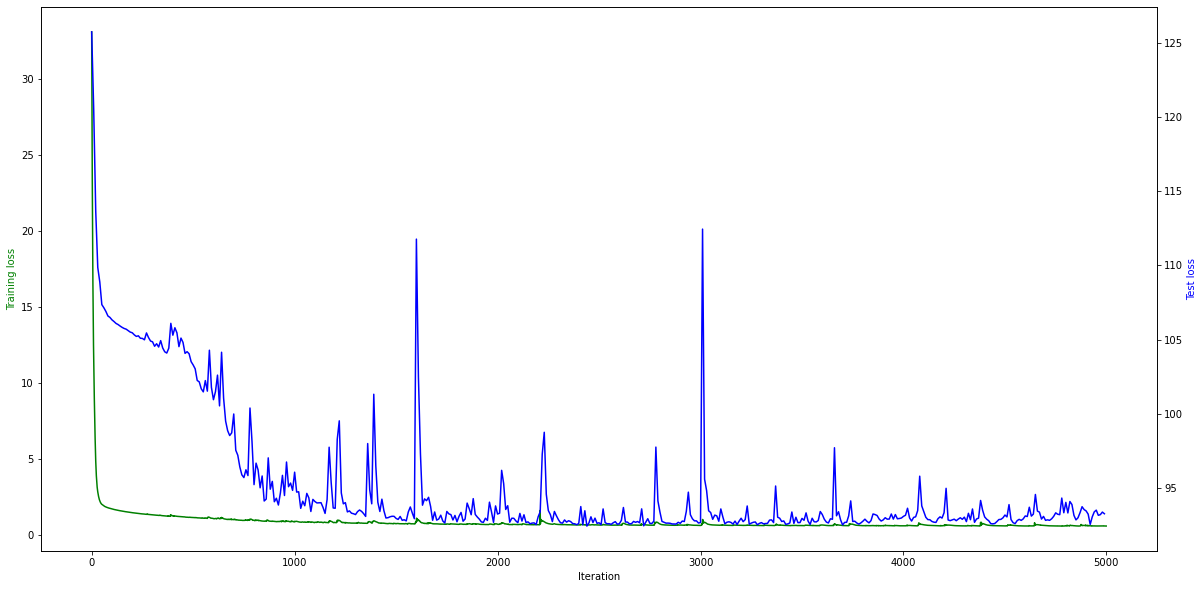

In [15]:
fig, ax1 = plt.subplots(figsize=(20,10))

ax2 = ax1.twinx()
ax1.plot(np.arange(len(list_training_loss)), list_training_loss, 'g-')
ax2.plot(np.arange(len(list_test_pred_error))*num_iter_test, list_test_pred_error, 'b-')

ax1.set_xlabel('Iteration')
ax1.set_ylabel('Training loss', color='g')
ax2.set_ylabel('Test loss', color='b')

best_iter = (np.where(np.asarray(list_training_loss)==np.min(list_training_loss))[0][0]//num_iter_test)*num_iter_test
best_pred_error = list_test_pred_error[best_iter//num_iter_test]

print ('Best predictions at iter: %d (error: %f)' % (best_iter, best_pred_error))
RMSE = np.sqrt(np.square(best_pred_error)/np.sum(Otest))
print ('RMSE: %f' % RMSE)

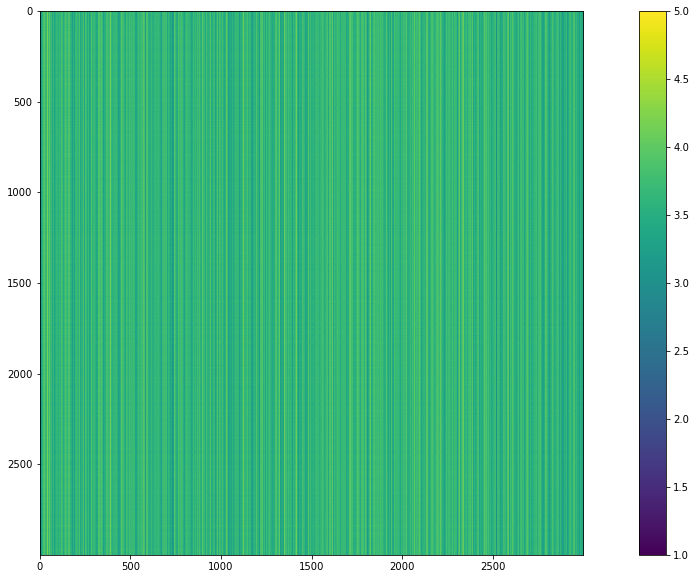

In [16]:
#last X generated
plt.figure(figsize=(20,10))
plt.imshow(X)
plt.colorbar()